**1. Import packages**

In [6]:
from __future__ import print_function
from __future__ import division

import math
import time
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

**2. Check Cuda Availability**

In [7]:
assert torch.cuda.is_available(), 'GPU unavailable'

**3. CIFAR-10, 60k 32 X 32 images**

In [8]:
def get_CIFAR10_data():
  """
  Load the CIFAR-10 dataset and prepare it for the linear classifier.
  """
  CIFAR10_train = CIFAR10(root='.', train=True, download=True)
  CIFAR10_test = CIFAR10(root='.', train=False, download=True)
  X_train = torch.Tensor(CIFAR10_train.data).permute(0, 3, 1, 2) / 255  # 50K x 3 x 32 x 32
  X_test = torch.Tensor(CIFAR10_test.data).permute(0, 3, 1, 2) / 255  # 10K x 3 x 32 x 32
  y_train = torch.LongTensor(CIFAR10_train.targets)  # 50K
  y_test = torch.LongTensor(CIFAR10_test.targets)  # 10K

  # Normalize the data so that the pixel values have zero mean and unit variance
  RGB_std, RGB_mean = torch.std_mean(X_train, dim=(0, 2, 3), keepdim=True)
  X_train = (X_train - RGB_mean) / RGB_std
  X_test = (X_test - RGB_mean) / RGB_std
  print('RGB_mean:', RGB_mean.squeeze())
  print('RGB_std:', RGB_std.squeeze())

  # Flatten each image into a vector
  X_train = X_train.reshape(X_train.shape[0], -1)
  X_test = X_test.reshape(X_test.shape[0], -1)

  # Bias trick
  ones_train = torch.ones_like(y_train).view(-1, 1)
  ones_test = torch.ones_like(y_test).view(-1, 1)
  X_train = torch.cat([X_train, ones_train], dim=1)
  X_test = torch.cat([X_test, ones_test], dim=1)

  # Carve out part of the training data to use for validation
  num_train = 40000
  torch.manual_seed(0)
  indices = torch.randperm(X_train.shape[0])
  X_val = X_train[indices[num_train:]]
  y_val = y_train[indices[num_train:]]
  X_train = X_train[indices[:num_train]]
  y_train = y_train[indices[:num_train]]

  # Return the dataset as a dictionary
  data_dict = {}
  data_dict['X_train'] = X_train.cuda()
  data_dict['y_train'] = y_train.cuda()
  data_dict['X_val'] = X_val.cuda()
  data_dict['y_val'] = y_val.cuda()
  data_dict['X_test'] = X_test.cuda()
  data_dict['y_test'] = y_test.cuda()
  return data_dict

# Invoke the above function to get our data
data_dict = get_CIFAR10_data()
print('Training data shape:', data_dict['X_train'].shape)
print('Training labels shape:', data_dict['y_train'].shape)
print('Validation data shape:', data_dict['X_val'].shape)
print('Validation labels shape:', data_dict['y_val'].shape)
print('Test data shape:', data_dict['X_test'].shape)
print('Test labels shape:', data_dict['y_test'].shape)

Files already downloaded and verified
Files already downloaded and verified
RGB_mean: tensor([0.4914, 0.4822, 0.4465])
RGB_std: tensor([0.2470, 0.2435, 0.2616])
Training data shape: torch.Size([40000, 3073])
Training labels shape: torch.Size([40000])
Validation data shape: torch.Size([10000, 3073])
Validation labels shape: torch.Size([10000])
Test data shape: torch.Size([10000, 3073])
Test labels shape: torch.Size([10000])


**4. Stable Softmax**

In [9]:
def softmax_stable(z):
  y = torch.exp(z - z.max())/(torch.exp(z - z.max())).sum()
  return y

**Test Validity**

In [10]:
def max_diff(actual, expected):
  return (actual - expected).abs().max().item()

In [11]:
z1 = torch.tensor([1.0, 1.0, 1.0, 1.0])
assert max_diff(softmax_stable(z1), torch.tensor([0.25, 0.25, 0.25, 0.25])) == 0

z2 = torch.tensor([1.0, 2.0, 3.0])
assert max_diff(softmax_stable(z2), torch.nn.functional.softmax(z2, dim=0)) < 1e-4

z3 = torch.tensor([100.0, 200.0, 300.0])
assert max_diff(softmax_stable(z3), torch.nn.functional.softmax(z3, dim=0)) < 1e-4

**5. SoftMax loss computation**

In [12]:
def softmax_loss_vectorized(W, X, y, reg):
  ## O computation
  matrix_O = torch.matmul(X,W)

  ## Stable softmax
  matrix_P = torch.exp(matrix_O - matrix_O.max(dim=1, keepdim=True)[0]) / torch.exp(matrix_O - matrix_O.max(dim=1,keepdim=True)[0]).sum(dim = 1, keepdim = True)
  matrix_log = torch.zeros((X.shape[0],W.shape[1]), dtype=torch.float64, device='cuda')

  ## Negative Logarithm and loss
  row_vec = torch.arange(X.shape[0])
  matrix_log[row_vec,y] = 1.
  nl_vec = (-1 * matrix_log*torch.log(matrix_P)).sum(dim=1)
  loss = nl_vec.mean() + reg/2 * (W.norm(dim=0,p=2)**2).sum()

  # gradient Computation
  temp_P_mat = matrix_P.clone()
  temp_P_mat[row_vec,y] -= 1.
  dW = X.transpose(0,1).mm(temp_P_mat) / X.shape[0] + reg*W
  return loss, dW

**6. Training**

In [13]:
def train_linear_classifier(loss_func, W, X, y, learning_rate=1e-3, 
                            reg=1e-5, num_iters=100, batch_size=200, verbose=False):
  N, D = X.shape
  if W is None:
    K = torch.max(y).item() + 1
    W = X.new_empty(D, K).normal_() * 1e-2
  else:
    K = W.shape[1]

  # Run stochastic gradient descent to optimize W
  loss_history = []
  for it in range(num_iters):
    X_batch = None
    y_batch = None
    rand_index_vec = torch.randint(0,X.shape[0], (batch_size,))
    X_batch = X[rand_index_vec,:]
    y_batch = y[rand_index_vec]

    # Compute loss and gradient
    loss, grad = loss_func(W, X_batch, y_batch, reg)
    loss_history.append(loss.item())

    # Perform parameter update
    W -= learning_rate * grad

    if verbose and it % 100 == 0:
      print('iteration %d / %d: loss %f' % (it, num_iters, loss))

  return W, loss_history

**7. Display loss history**

In [14]:
W, loss_hist = train_linear_classifier(softmax_loss_vectorized, None,
                                       data_dict['X_train'],
                                       data_dict['y_train'],
                                       learning_rate=1e-6, reg=1e4,
                                       num_iters=200, verbose=True)

iteration 0 / 200: loss 15291.559163
iteration 100 / 200: loss 2050.728296


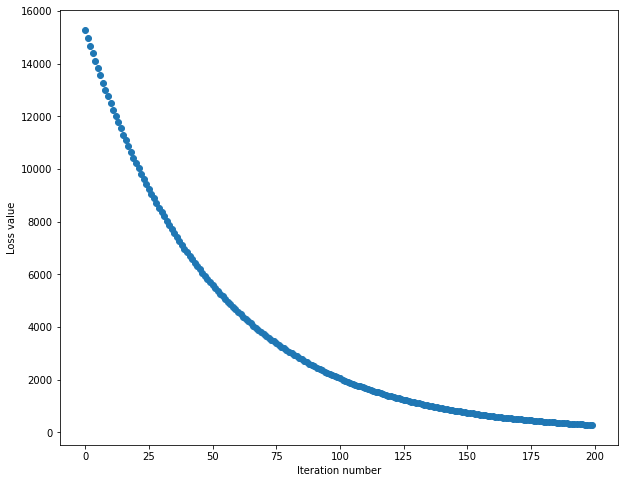

In [15]:
plt.plot(loss_hist, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

**8.Prediction**

In [16]:
def predict_linear_classifier(W, X):
  y_pred = X.mm(W).max(dim=1)[1]
  return y_pred

**9. Cross Validation**

In [17]:
class LinearClassifier:

  def __init__(self):
    self.W = None

  def train(self, X_train, y_train, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    train_args = (self.loss, self.W, X_train, y_train, learning_rate, reg,
                  num_iters, batch_size, verbose)
    self.W, loss_history = train_linear_classifier(*train_args)
    return loss_history

  def predict(self, X):
    return predict_linear_classifier(self.W, X)

  def loss(self, W, X_batch, y_batch, reg):
    return softmax_loss_vectorized(W, X_batch, y_batch, reg)

In [18]:
results = {}
best_model = None
total_size = data_dict['y_train'].shape[0]
cut_off = math.floor(total_size/15*14)

learn_rt = 1e-3
lmd = 1e-3
prev_acc = None
prev_lr = None
prev_reg = None

for i in range(10):
  rand_id = torch.randperm(total_size)[:total_size]
  train_ind = rand_id[:cut_off]
  test_ind = rand_id[cut_off:]

  lc = LinearClassifier()
  lc.W = torch.ones(3073, 10, device='cuda')
  lossh = lc.train(X_train = data_dict['X_train'][train_ind], y_train = data_dict['y_train'][train_ind], learning_rate=learn_rt, reg=lmd, num_iters=10000)

  y_hat_train = lc.predict(data_dict['X_train'][train_ind])
  y_hat_test = lc.predict(data_dict['X_train'][test_ind])
  print('Learning rate: %.5f' % learn_rt)
  print('reg_str: %.5f' % lmd)

  train_acc = 100.0 * (data_dict['y_train'][train_ind] == y_hat_train).float().mean().item()
  print('training accuracy: %.2f%%' % train_acc)
  validation_acc = 100.0 * (data_dict['y_train'][test_ind] == y_hat_test).float().mean().item()
  print('validation accuracy: %.2f%%' % validation_acc)

  if best_model == None:
    best_model = lc
    prev_acc = validation_acc
  else:
    if validation_acc > prev_acc:
      best_model = lc
      prev_acc = validation_acc
      prev_lr = learn_rt
      prev_reg = lmd

  results[(learn_rt,lmd)] = (train_acc,validation_acc)
  print()
  print()
  learn_rt += 1e-4
  lmd += 1e-4

print("best Learning rate: %.5f" % prev_lr)
print("best reg: %.5f" % prev_reg)


Learning rate: 0.00100
reg_str: 0.00100
training accuracy: 43.79%
validation accuracy: 41.28%


Learning rate: 0.00110
reg_str: 0.00110
training accuracy: 43.86%
validation accuracy: 42.03%


Learning rate: 0.00120
reg_str: 0.00120
training accuracy: 44.07%
validation accuracy: 40.19%


Learning rate: 0.00130
reg_str: 0.00130
training accuracy: 44.07%
validation accuracy: 41.36%


Learning rate: 0.00140
reg_str: 0.00140
training accuracy: 44.15%
validation accuracy: 40.83%


Learning rate: 0.00150
reg_str: 0.00150
training accuracy: 44.16%
validation accuracy: 42.56%


Learning rate: 0.00160
reg_str: 0.00160
training accuracy: 44.37%
validation accuracy: 42.82%


Learning rate: 0.00170
reg_str: 0.00170
training accuracy: 45.00%
validation accuracy: 39.03%


Learning rate: 0.00180
reg_str: 0.00180
training accuracy: 44.68%
validation accuracy: 39.90%


Learning rate: 0.00190
reg_str: 0.00190
training accuracy: 45.04%
validation accuracy: 40.23%


best Learning rate: 0.00160
best reg: 0.

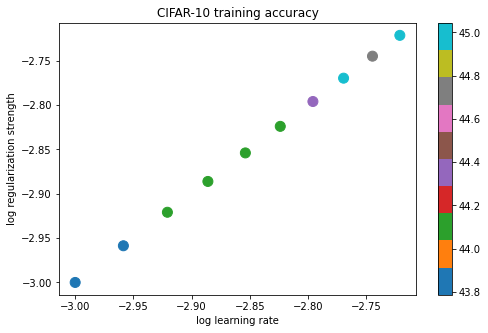

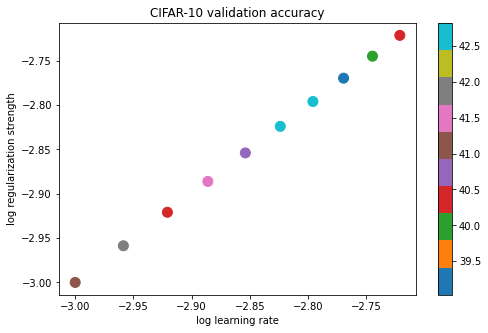

best validation accuracy: 41.06%


In [19]:
x_scatter = [math.log10(param[0]) for param in results]
y_scatter = [math.log10(param[1] + 1e-10) for param in results]

# Plot training accuracy
marker_size = 100
colors = [results[param][0] for param in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='tab10')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

# Plot validation accuracy
marker_size = 100
colors = [results[param][1] for param in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='tab10')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

# Print best validation accuracy
y_val_pred = best_model.predict(data_dict['X_val'])
val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).float().mean().item()
print('best validation accuracy: %.2f%%' % val_acc)

**10. Testing**

In [20]:
y_test_pred = best_model.predict(data_dict['X_test'])
test_acc = 100.0 * (data_dict['y_test'] == y_test_pred).float().mean().item()
print('test accuracy: %.2f%%' % test_acc)

test accuracy: 40.56%


**11. Visualization**

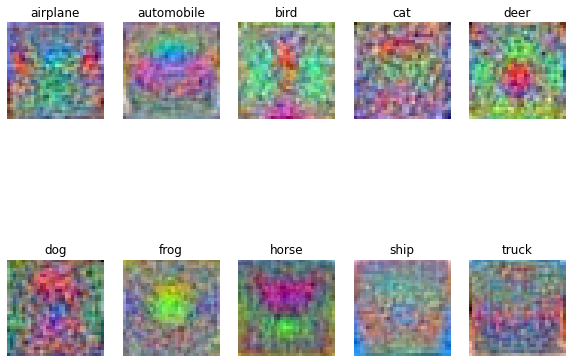

In [21]:
w = best_model.W[:-1]  # strip out the bias
w = w.reshape(3, 32, 32, 10)
w = w.permute(1, 2, 0, 3)

# Rescale the weights to be between 0 and 1
w_min = torch.amin(w, dim=(0,1,2), keepdim=True)
w_max = torch.amax(w, dim=(0,1,2), keepdim=True)
w_img = (w - w_min) / (w_max - w_min)
w_img = w_img.cpu()

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(w_img[..., i])
  plt.axis('off')
  plt.title(classes[i])